In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.notebook import Nb
from ncbi_remap.plotting import make_figs

In [2]:
# Setup notebook
nbconfig = Nb.setup_notebook()

Please check output/fbgn2chrom.tsv. If it does not exist, run bin/fbgn2chrom.py
last updated: 2018-10-01 
Git hash: e661446c073541ec5d8ce0ef424e3221bd0e4094


In [3]:
# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')

In [4]:
# Set of figures
mpl.rcParams['figure.figsize'] = 7, 7
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['font.size'] = 12
mpl.rcParams['grid.linewidth'] = 1.3
mpl.rcParams['legend.fontsize'] = 8.0
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlesize'] = 11
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markeredgewidth'] = 0.02
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['patch.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 10.0
mpl.rcParams['xtick.major.pad'] = 9.1
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.labelsize'] = 10.0
mpl.rcParams['ytick.major.pad'] = 9.1
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 1

In [5]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sramongo']
ncbi = db['ncbi']

In [6]:
complete = store['aln/complete'].srx.unique().tolist()

In [7]:
rnaseq_srx = [x['_id'] for x in ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': complete},
            'sra.experiment.library_strategy': 'RNA-Seq'
        }
    },
    {
        '$project': {
            '_id': 1
        }
    }
])]

In [9]:
metadata = pd.read_csv('../output/geo-wf/rnaseq_metadata.tsv', sep='\t')

In [27]:
testis_srx = metadata[metadata.tissue == 'testis'].sample_name.values
print(len(testis_srx))

109


In [26]:
cnts = pd.read_parquet('../output/aln-downstream-wf/gene_counts_wide.parquet', columns=testis_srx)

In [30]:
_corr = cnts.corr(method='spearman')

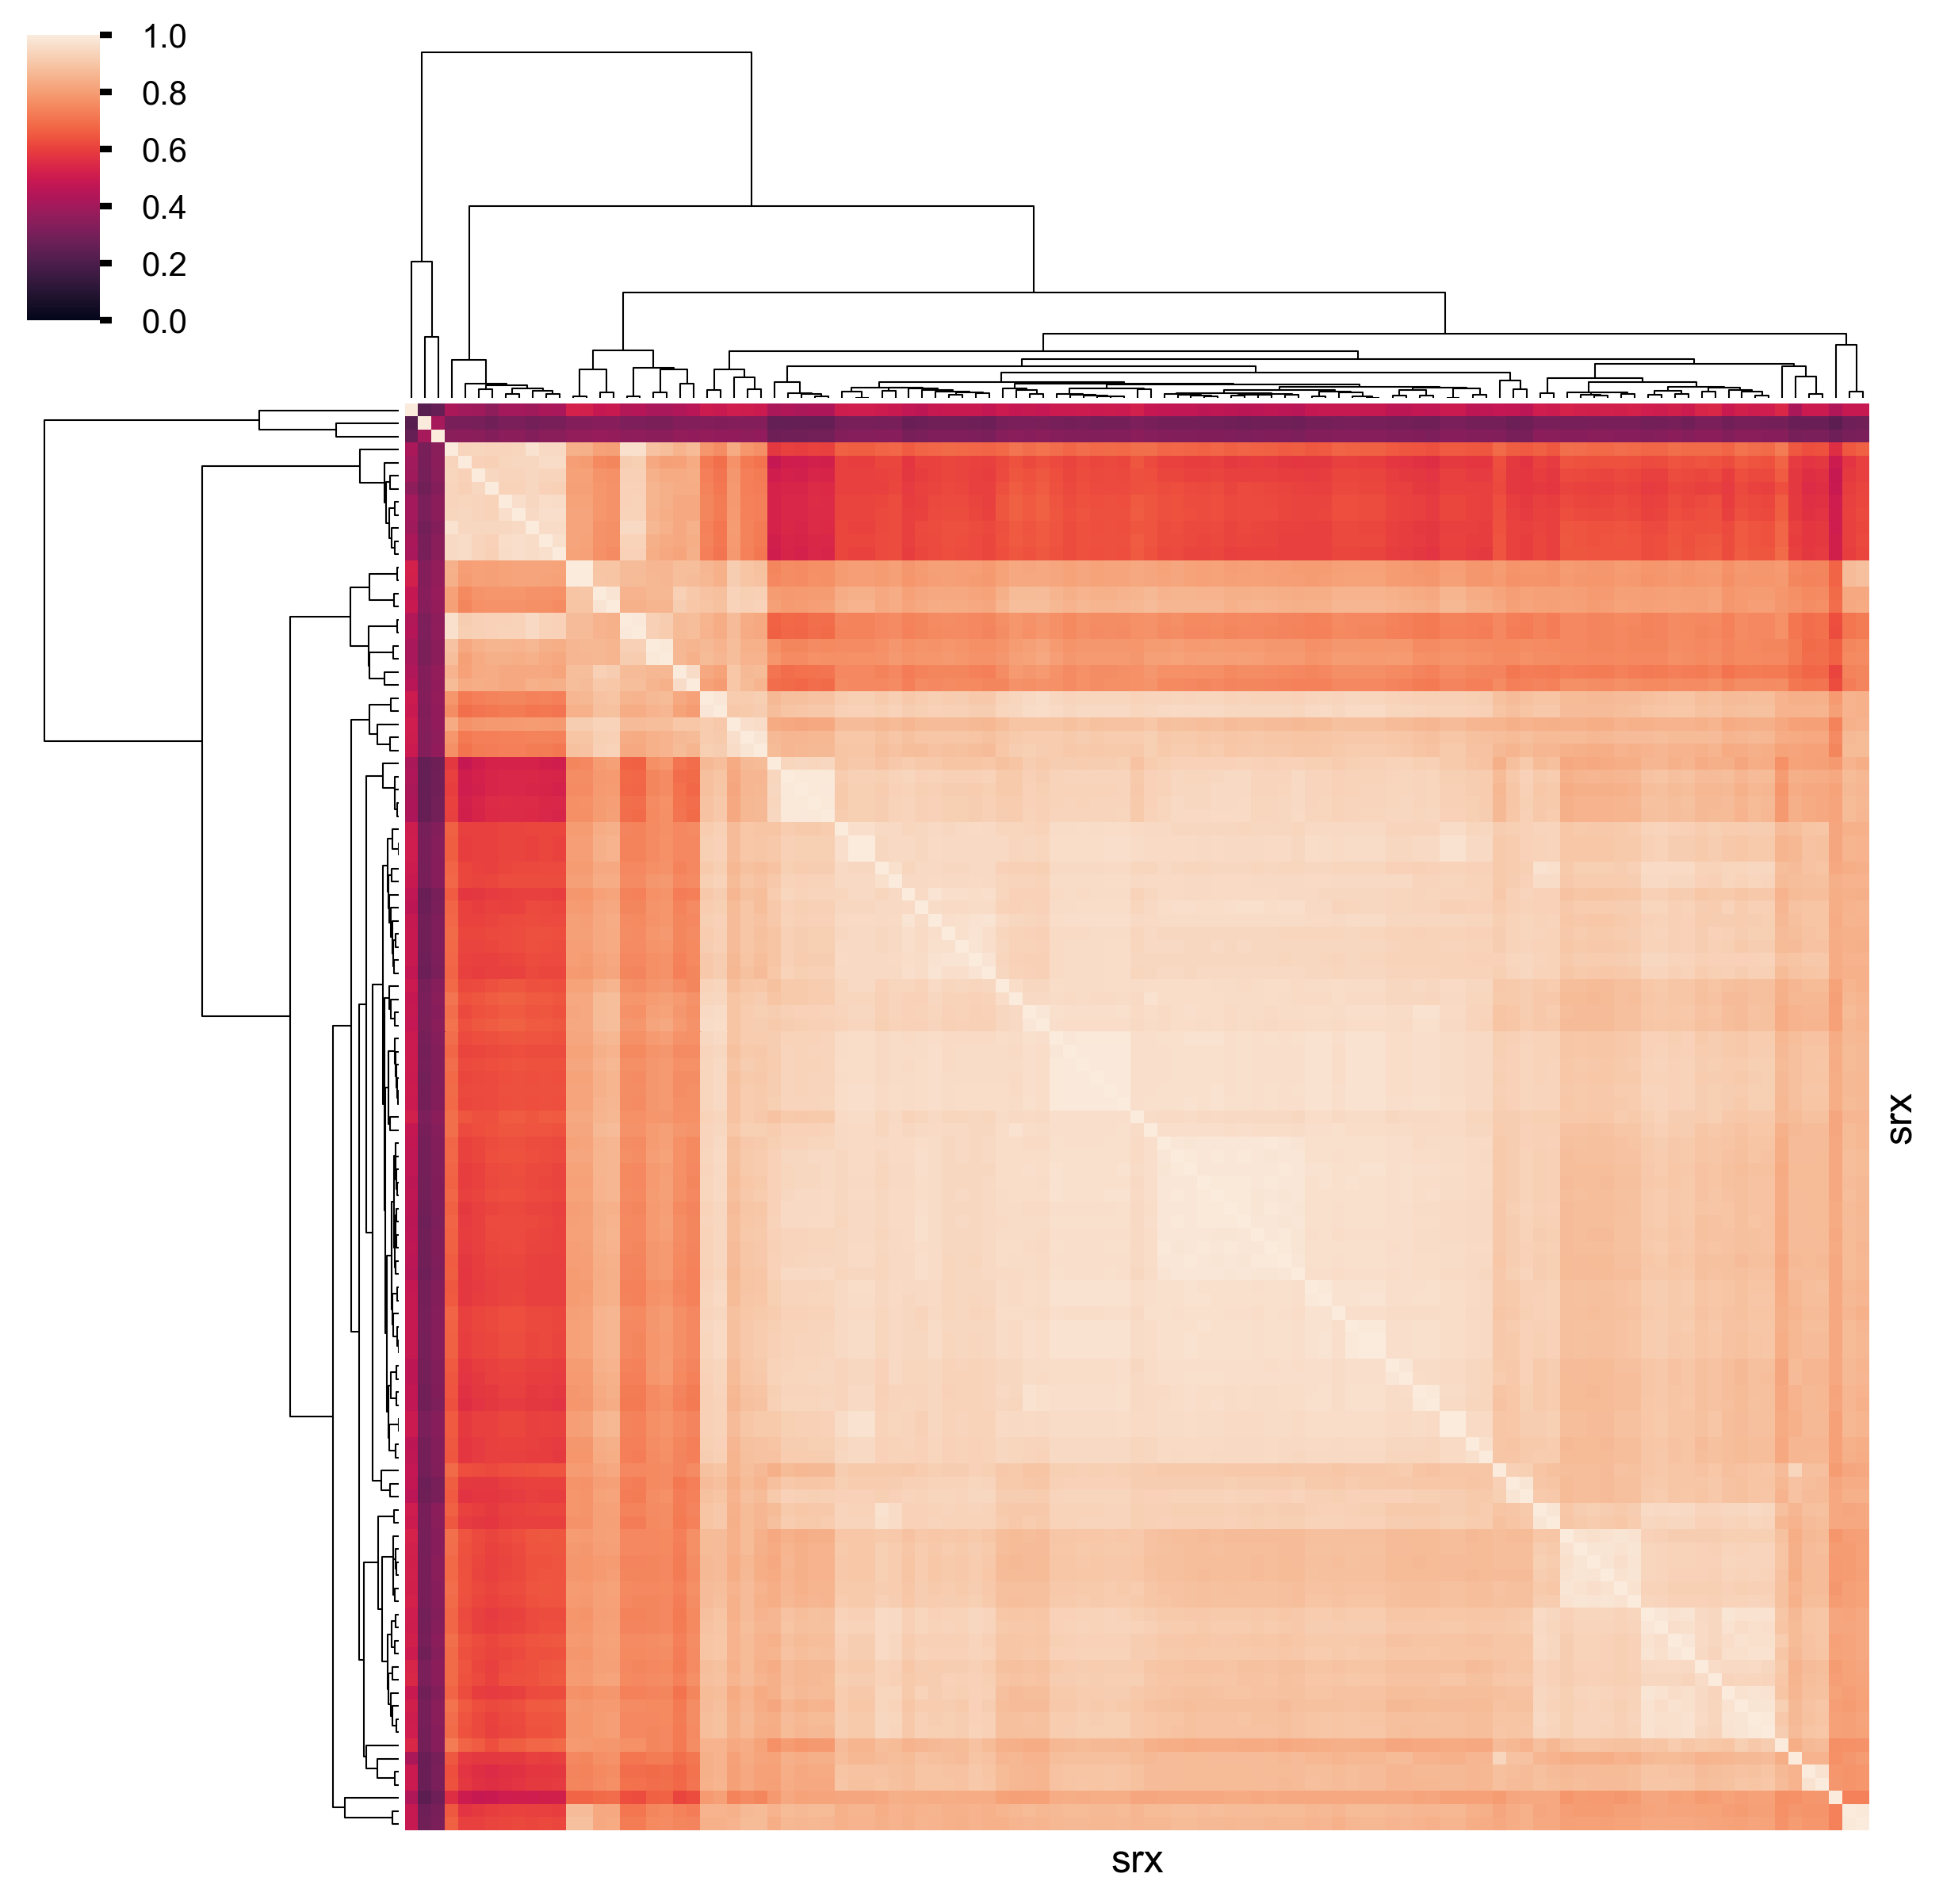

In [71]:
sns.clustermap(_corr, xticklabels=False, yticklabels=False, vmin=0, vmax=1)

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest

### Split data by library stategy

In [45]:
clf = make_pipeline(
    StandardScaler(), 
    PCA(n_components=12), 
    IsolationForest(behaviour='new', max_samples='auto', contamination='auto')
)

In [46]:
outliers = clf.fit_predict(cnts.T)

/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/fearjm/miniconda3/envs/ncbi_remap/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [52]:
df_outlier = pd.DataFrame(outliers, index=cnts.columns)
df_outlier.columns=['flag_outlier']

In [62]:
bad = df_outlier[df_outlier.flag_outlier == -1].index

In [67]:
len(bad)

10

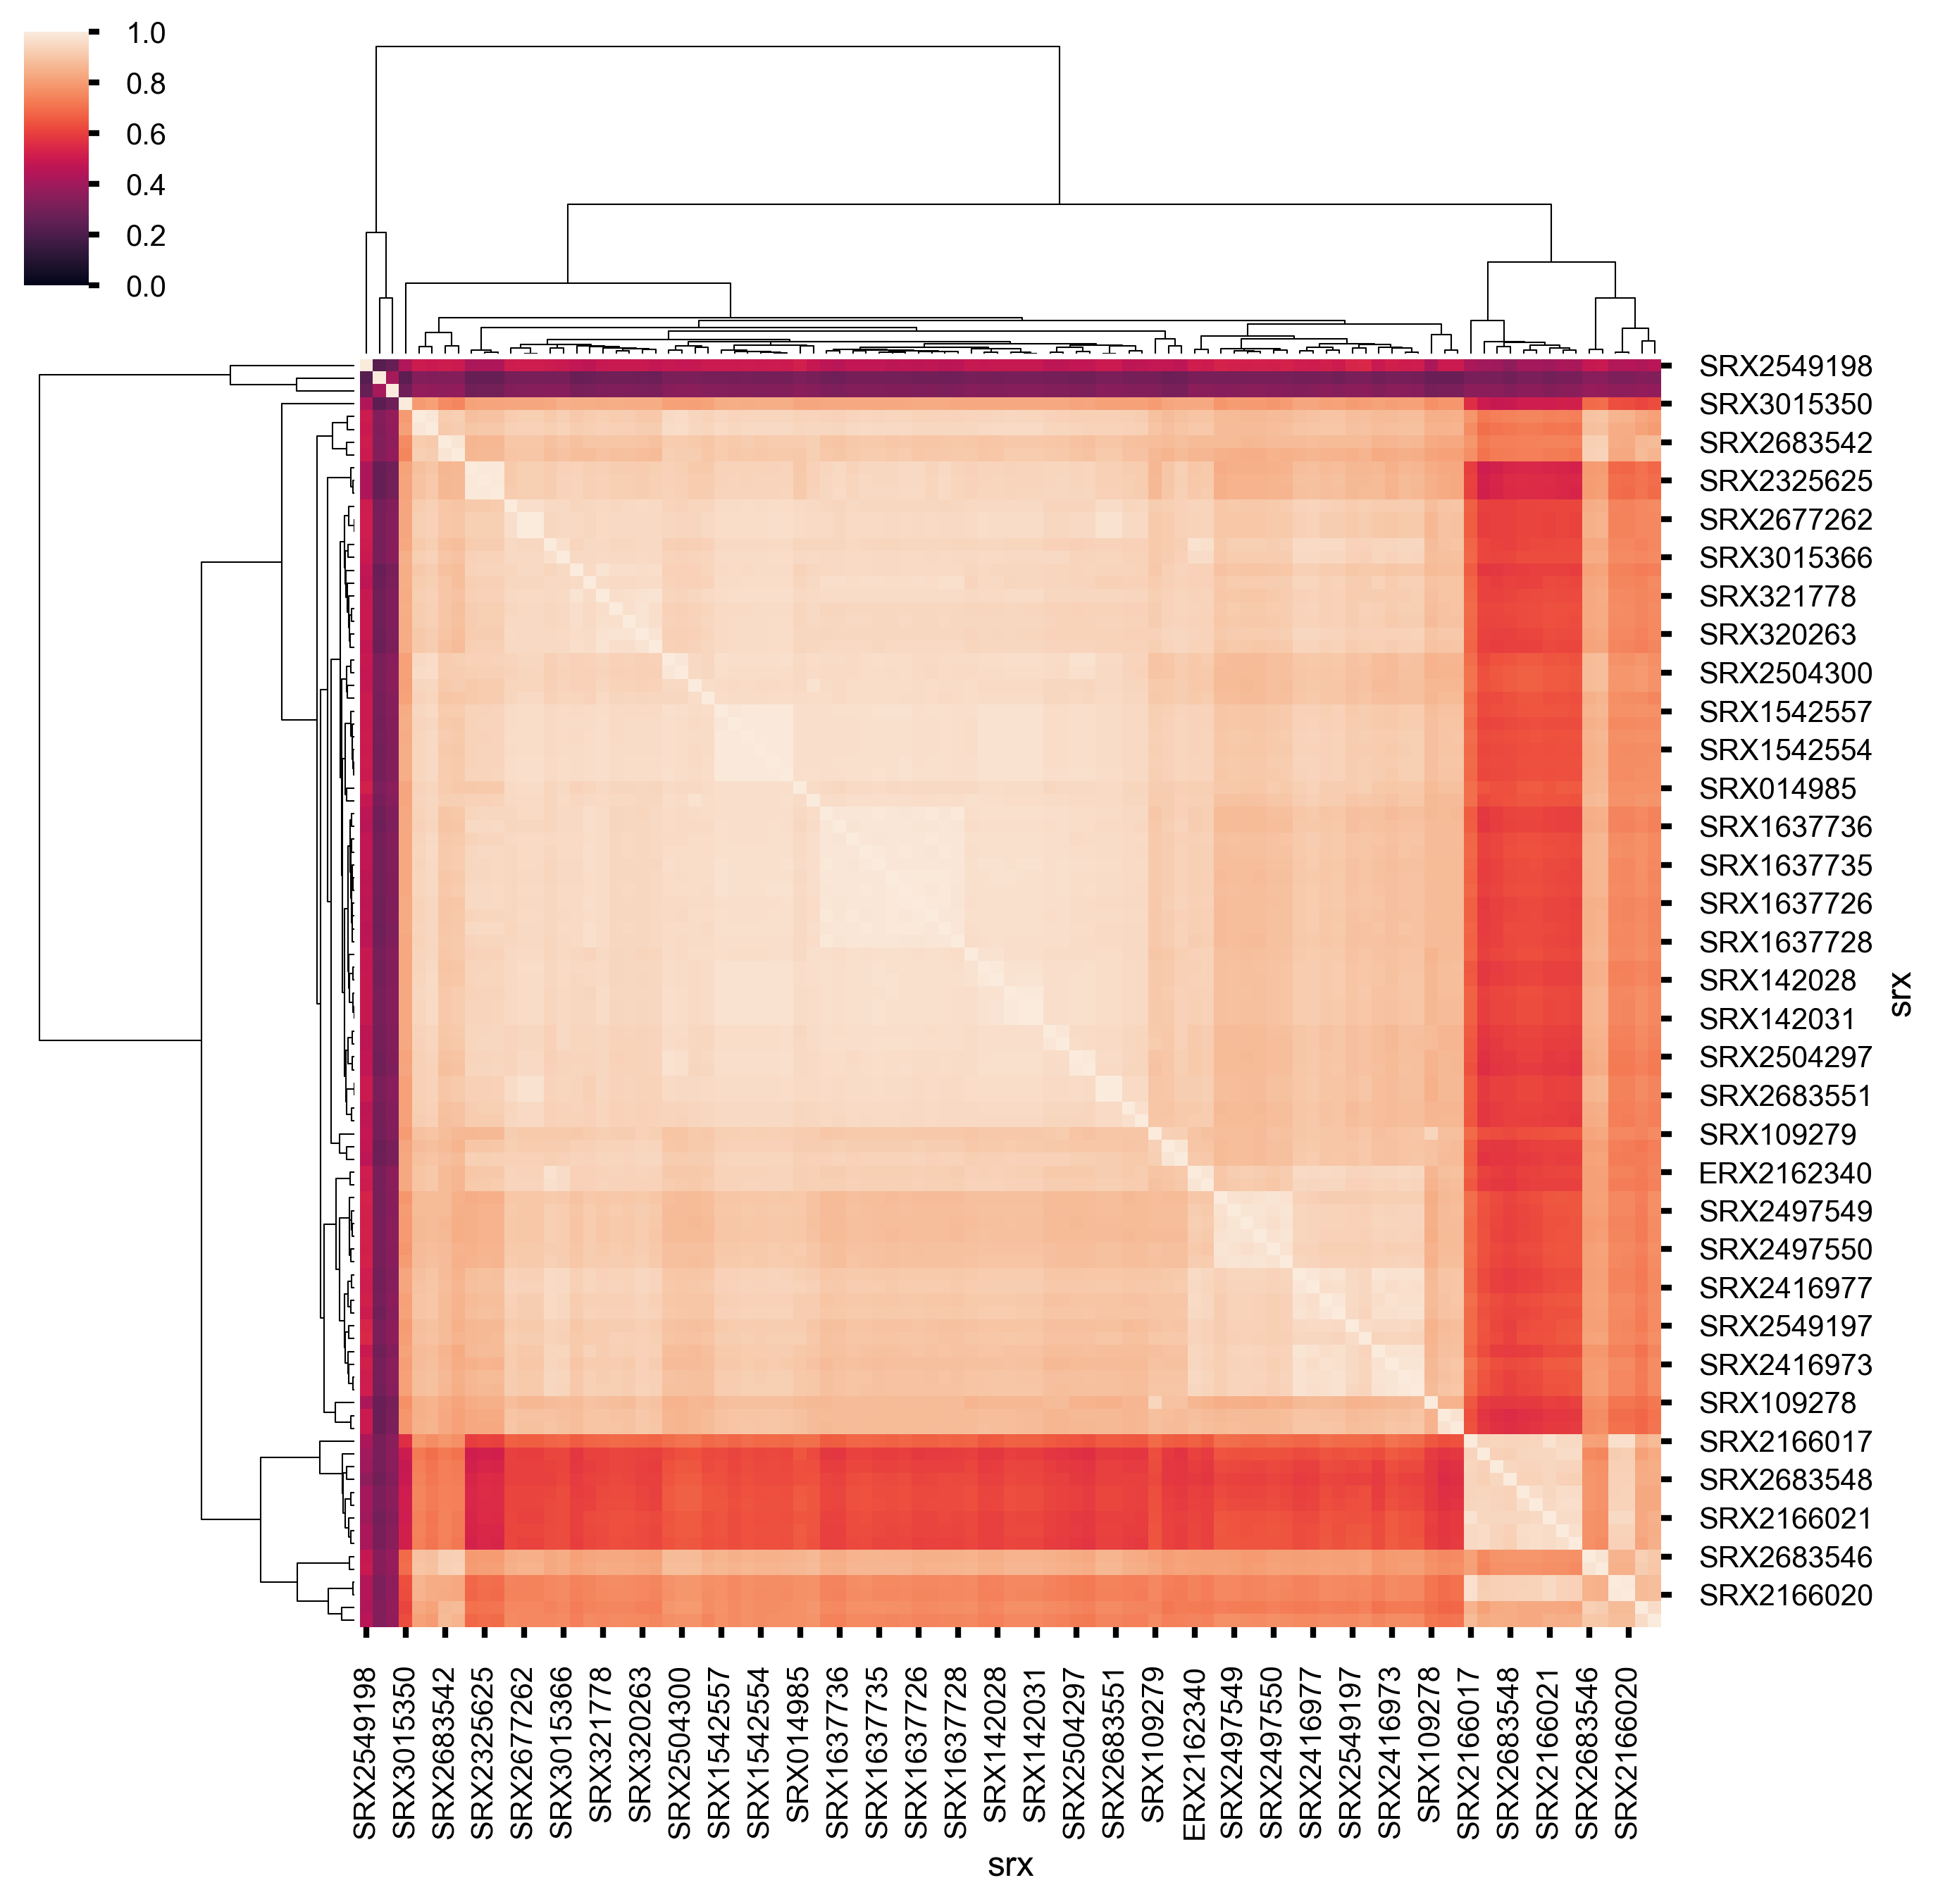

In [72]:
sns.clustermap(cnts.loc[:, ~cnts.columns.isin(bad)].corr(method='spearman'), vmin=0, vmax=1)

In [82]:
bob1 = clf.steps[2][1]
bob2 = clf.steps[1][1].transform(cnts.T)

In [83]:
bob1.score_samples(bob2)

array([-0.68873, -0.66886, -0.68873, -0.62886, -0.68423, -0.71403,
       -0.69953, -0.67303, -0.66133, -0.66288, -0.68423, -0.40302,
       -0.52523, -0.66133, -0.66133, -0.66133, -0.66133, -0.66133,
       -0.66133, -0.66133, -0.66133, -0.66133, -0.66133, -0.66133,
       -0.66133, -0.655  , -0.655  , -0.655  , -0.655  , -0.68556,
       -0.655  , -0.655  , -0.655  , -0.655  , -0.655  , -0.66133,
       -0.655  , -0.66133, -0.66133, -0.69348, -0.69348, -0.69497,
       -0.63783, -0.65703, -0.62257, -0.62257, -0.62257, -0.64791,
       -0.66095, -0.66095, -0.66095, -0.66729, -0.66095, -0.64275,
       -0.66095, -0.64275, -0.68313, -0.68313, -0.65815, -0.68313,
       -0.68313, -0.68313, -0.68313, -0.68313, -0.68873, -0.68313,
       -0.68873, -0.68873, -0.68313, -0.68313, -0.66133, -0.66133,
       -0.66133, -0.66133, -0.71403, -0.63774, -0.6815 , -0.66133,
       -0.66133, -0.66133, -0.66133, -0.63611, -0.66883, -0.66883,
       -0.69064, -0.69064, -0.66133, -0.69064, -0.67067, -0.62